In [29]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from IPython.display import display, FileLink

from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Submission format

In [30]:
df_smp = pd.read_csv("data/house-sample-subm.csv", low_memory=False)
df_smp.head(3)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570


### Define functions

In [31]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

### Read in data

In [32]:
df_trn_raw = pd.read_csv("data/house-train.csv", low_memory=False)

### Display all

In [33]:
display_all(df_trn_raw.head(5).T)

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


### Delete columns

In [34]:
del df_trn_raw["Id"]

### Convert target variable

In [35]:
df_trn_raw["SalePrice"] = np.log(df_trn_raw["SalePrice"])

### Handle missing data

In [36]:
pct_null = df_trn_raw.isnull().sum() / len(df_trn_raw)
pd.DataFrame(pct_null, columns=["Frequency"])[pct_null != 0].sort_values(by="Frequency", ascending=False)

,Frequency
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageType,0.055479
GarageYrBlt,0.055479
GarageFinish,0.055479
GarageQual,0.055479


* **PoolQC** - 0.995205 - Pool quality
* **MiscFeature** - 0.963014 - Miscellaneous feature not covered in other categories
* **Alley** - 0.937671 - Type of alley access
* **Fence** - 0.807534 - Fence quality
* **FireplaceQu** - 0.472603 - Fireplace quality

In [37]:
df_trn_raw["PoolArea"].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [38]:
df_trn_raw["MiscFeature"].value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [39]:
df_trn_raw["Alley"].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [40]:
df_trn_raw["Fence"].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [41]:
df_trn_raw["FireplaceQu"].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Most of these should be covered by proc_df and the {}_na feature right?

### Convert strings

In [43]:
??proc_df

In [49]:
train_cats(df_trn_raw)
X_trn, y_trn, nas = proc_df(df_trn_raw, "SalePrice")

### Add columns for missing data present in test but not trn

In [53]:
df_test_raw = pd.read_csv("data/house-test.csv", low_memory=False)

train_cats(df_test_raw)
df_test_raw["_"] = "_"

X_test, _, nas = proc_df(df_test_raw, "_")
del X_test["Id"]

In [54]:
not_in_trn = []

for c in X_test.columns:
    if c not in X_trn.columns:
        print(c)
        not_in_trn.append(c)

BsmtFinSF1_na
BsmtFinSF2_na
BsmtUnfSF_na
TotalBsmtSF_na
BsmtFullBath_na
BsmtHalfBath_na
GarageCars_na
GarageArea_na


In [55]:
for c in not_in_trn:
    X_trn[c] = 0

### Create (multiple?) validation set(s)

In [56]:
df_test_raw = pd.read_csv("data/house-sample-subm.csv", low_memory=False)
print(len(df_test_raw))
print(len(X_trn))

1459
1460


In [57]:
n_trn = math.ceil(len(X_trn) * 0.75)

**Val w/o shuffle**

In [58]:
def split_vals(a, n): return a[:n], a[n:]

In [59]:
X_trn_noshuf, X_val_noshuf = split_vals(X_trn, n_trn)
y_trn_noshuf, y_val_noshuf = split_vals(y_trn, n_trn)

**Val w/shuffle**

In [ ]:
# Skip (val RMSE is really close to KG)

### Train & score model

In [60]:
def rmse(x, y): return math.sqrt(((x - y) ** 2).mean())

def rf_eval(m, x_trn, y_trn, x_val, y_val):
    print("Trn RMSE : {}\nVal RMSE : {}\nTrn Score: {}\nVal Score: {}".format(
        rmse(m.predict(x_trn), y_trn),
        rmse(m.predict(x_val), y_val),
        m.score(x_trn, y_trn),
        m.score(x_val, y_val)
    ))
    if hasattr(m, "oob_score_"):
        print("OOB Score: {}".format(m.oob_score_))

In [61]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_trn_noshuf, y_trn_noshuf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
rf_eval(m, X_trn_noshuf, y_trn_noshuf, X_val_noshuf, y_val_noshuf)

Trn RMSE : 0.06613517522306539
Val RMSE : 0.16130839782712159
Trn Score: 0.9732428110933415
Val Score: 0.8234725791401204


### (Optional) map validation sets to kaggle public leaderboard

In [ ]:
# Skip (val RMSE is really close to KG)

### Subsample dataset

In [ ]:
# Skip for now dataset is pretty small already

### Tune hyperparameters

In [63]:
%%time

estimators = [10, 20, 40, 100, 200, 400, 1000, 2000]
trn_rmse = []
val_rmse = []

for e in estimators:
    m = RandomForestRegressor(n_estimators=e, n_jobs=-1)
    m.fit(X_trn_noshuf, y_trn_noshuf)
    trn_rmse.append(rmse(m.predict(X_trn_noshuf), y_trn_noshuf))
    val_rmse.append(rmse(m.predict(X_val_noshuf), y_val_noshuf))

CPU times: user 1min 16s, sys: 720 ms, total: 1min 17s
Wall time: 15.3 s


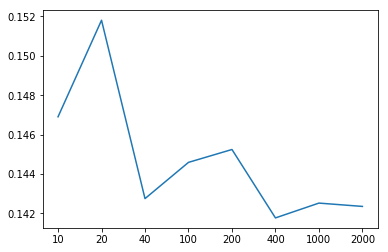

In [64]:
plt.plot(val_rmse)
_ = plt.xticks(np.arange(len(estimators)), estimators)

In [65]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_trn_noshuf, y_trn_noshuf)
rf_eval(m, X_trn_noshuf, y_trn_noshuf, X_val_noshuf, y_val_noshuf)

Trn RMSE : 0.05528180457731922
Val RMSE : 0.14751931994710937
Trn Score: 0.9813043792119366
Val Score: 0.8523627238512461


In [66]:
%%time

leaf_samples = [1, 3, 5, 10, 25, 50]
trn_rmse = []
val_rmse = []

for l in leaf_samples:
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=l, n_jobs=-1)
    m.fit(X_trn_noshuf, y_trn_noshuf)
    trn_rmse.append(rmse(m.predict(X_trn_noshuf), y_trn_noshuf))
    val_rmse.append(rmse(m.predict(X_val_noshuf), y_val_noshuf))

CPU times: user 2.58 s, sys: 36 ms, total: 2.61 s
Wall time: 2.62 s


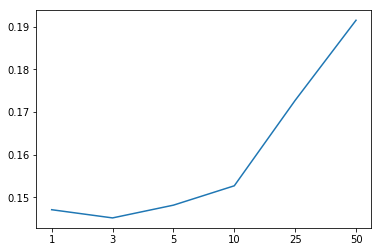

In [67]:
plt.plot(val_rmse)
_ = plt.xticks(np.arange(len(leaf_samples)), leaf_samples)

In [68]:
%%time

features = [None, 0.5, "sqrt", "log2"]
trn_rmse = []
val_rmse = []

for f in features:
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=f, n_jobs=-1)
    m.fit(X_trn_noshuf, y_trn_noshuf)
    trn_rmse.append(rmse(m.predict(X_trn_noshuf), y_trn_noshuf))
    val_rmse.append(rmse(m.predict(X_val_noshuf), y_val_noshuf))

CPU times: user 1.32 s, sys: 48 ms, total: 1.37 s
Wall time: 1.55 s


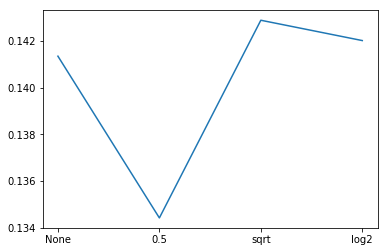

In [69]:
plt.plot(val_rmse)
_ = plt.xticks(np.arange(len(features)), features)

### Optimal

In [71]:
m = RandomForestRegressor(
    n_estimators=400,
    min_samples_leaf=3,
    max_features=0.5,
    n_jobs=-1
)
m.fit(X_trn_noshuf, y_trn_noshuf)
rf_eval(m, X_trn_noshuf, y_trn_noshuf, X_val_noshuf, y_val_noshuf)

Trn RMSE : 0.07792417544988568
Val RMSE : 0.13780196990439353
Trn Score: 0.9628533290524444
Val Score: 0.8711723535928856


Still overfitting like a lot

### Make a subm

In [78]:
df_test_raw = pd.read_csv("data/house-test.csv", low_memory=False)

In [79]:
df_test_raw["_"] = "_"
train_cats(df_test_raw)
X_test, _, nas = proc_df(df_test_raw, "_")
del X_test["Id"]

In [80]:
test_preds = m.predict(X_test)
subm = pd.DataFrame({
    "Id": df_test_raw["Id"],
    "SalePrice": np.exp(test_preds)
})
subm.to_csv("data/house-rfscaled-subm.csv", index=False)

FileLink("data/house-rfscaled-subm.csv")

/home/paperspace/nbs/data/house-rfscaled-subm.csv

### Identify feature importance

In [81]:
fi = rf_feat_importance(m, X_test)
fi[:10]

,cols,imp
16,OverallQual,0.330419
45,GrLivArea,0.159903
18,YearBuilt,0.094360
37,TotalBsmtSF,0.049496
60,GarageCars,0.043293
26,ExterQual,0.033080
42,1stFlrSF,0.031785
61,GarageArea,0.029890
48,FullBath,0.020232
33,BsmtFinSF1,0.018693


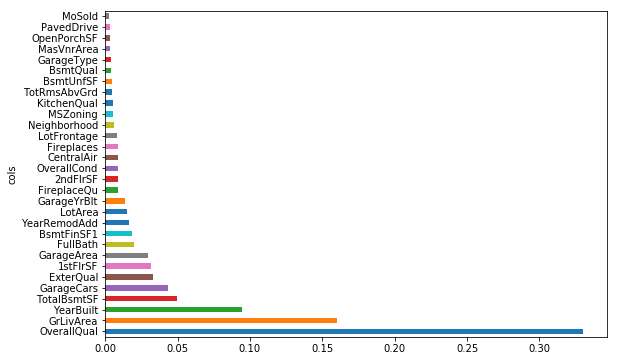

In [84]:
fi[:30].plot("cols", "imp", "barh", figsize=(9, 6), legend=False)

In [85]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

23

In [91]:
X_keep = X_trn[to_keep].copy()
X_trn_keep, X_val_keep = split_vals(X_keep, n_trn)

In [92]:
m = RandomForestRegressor(
    n_estimators=400,
    min_samples_leaf=3,
    max_features=0.5,
    n_jobs=-1
)
m.fit(X_trn_keep, y_trn_noshuf)
rf_eval(m, X_trn_keep, y_trn_noshuf, X_val_keep, y_val_noshuf)

Trn RMSE : 0.08248850376891068
Val RMSE : 0.13815698222228176
Trn Score: 0.9583742261857023
Val Score: 0.8705077141206982


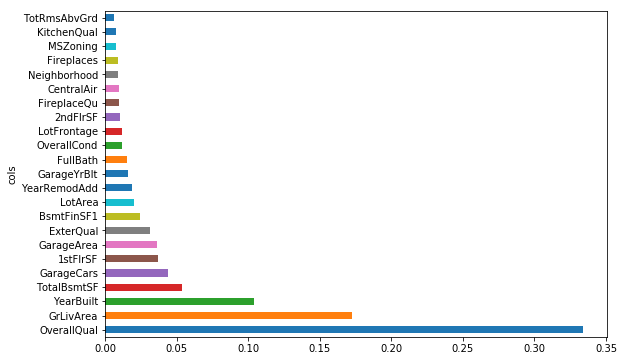

In [95]:
fi = rf_feat_importance(m, X_keep)
fi.plot("cols", "imp", "barh", figsize=(9, 6), legend=False)

* **OverallQual** - 0.330419 - Overall material and finish quality
* **GrLivArea**	- 0.159903 - Above grade (ground) living area square feet
* **YearBuilt**	- 0.094360 - Original construction date
* **TotalBsmtSF** - 0.049496 - Total square feet of basement area
* **GarageCars** - 0.043293 - Size of garage in car capacity

### Remove redundant features

In [98]:
from scipy.cluster import hierarchy as hc

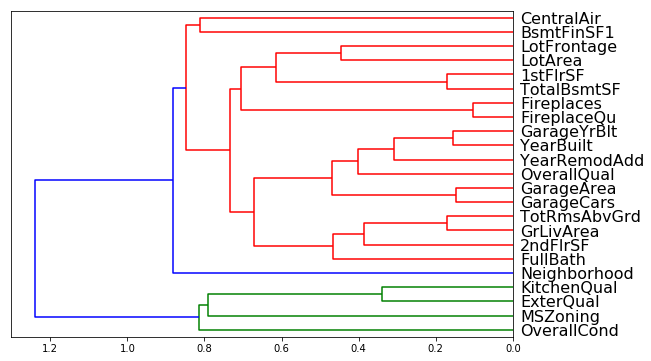

In [100]:
corr = np.round(scipy.stats.spearmanr(X_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method="average")
fig = plt.figure(figsize=(9, 6))
dendrogram = hc.dendrogram(z, labels=X_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Nothing to drop

### Try XTR

In [102]:
m = ExtraTreesRegressor(n_jobs=-1)
m.fit(X_trn_keep, y_trn_noshuf)
rf_eval(m, X_trn_keep, y_trn_noshuf, X_val_keep, y_val_noshuf)

Trn RMSE : 0.001198583816645856
Val RMSE : 0.1453184396097958
Trn Score: 0.9999912115499892
Val Score: 0.8567351423865199


CPU times: user 24.3 s, sys: 824 ms, total: 25.1 s
Wall time: 8.87 s


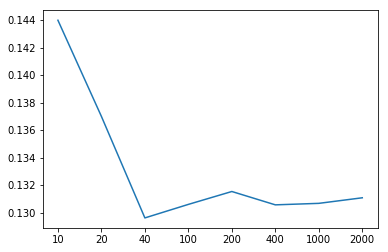

In [103]:
%%time

estimators = [10, 20, 40, 100, 200, 400, 1000, 2000]
trn_rmse = []
val_rmse = []

for e in estimators:
    m = ExtraTreesRegressor(n_estimators=e, n_jobs=-1)
    m.fit(X_trn_keep, y_trn_noshuf)
    trn_rmse.append(rmse(m.predict(X_trn_keep), y_trn_noshuf))
    val_rmse.append(rmse(m.predict(X_val_keep), y_val_noshuf))
    
plt.plot(val_rmse)
_ = plt.xticks(np.arange(len(estimators)), estimators)

CPU times: user 784 ms, sys: 32 ms, total: 816 ms
Wall time: 2.03 s


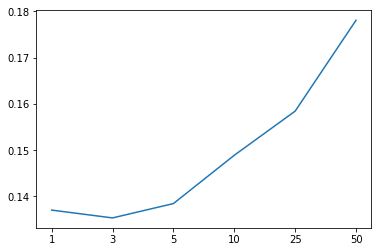

In [104]:
%%time

hp_vals = [1, 3, 5, 10, 25, 50]
trn_rmse = []
val_rmse = []

for p in hp_vals:
    m = ExtraTreesRegressor(n_estimators=40, min_samples_leaf=p, n_jobs=-1)
    m.fit(X_trn_keep, y_trn_noshuf)
    trn_rmse.append(rmse(m.predict(X_trn_keep), y_trn_noshuf))
    val_rmse.append(rmse(m.predict(X_val_keep), y_val_noshuf))
    
plt.plot(val_rmse)
_ = plt.xticks(np.arange(len(hp_vals)), hp_vals)

CPU times: user 416 ms, sys: 24 ms, total: 440 ms
Wall time: 1.37 s


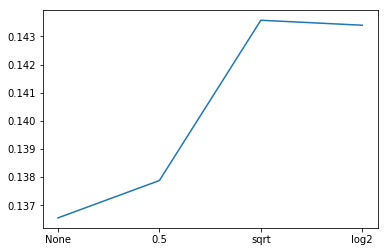

In [105]:
%%time

hp_vals = [None, 0.5, "sqrt", "log2"]
trn_rmse = []
val_rmse = []

for p in hp_vals:
    m = ExtraTreesRegressor(n_estimators=40, min_samples_leaf=3, max_features=p, n_jobs=-1)
    m.fit(X_trn_keep, y_trn_noshuf)
    trn_rmse.append(rmse(m.predict(X_trn_keep), y_trn_noshuf))
    val_rmse.append(rmse(m.predict(X_val_keep), y_val_noshuf))
    
plt.plot(val_rmse)
_ = plt.xticks(np.arange(len(hp_vals)), hp_vals)

### Optimal

In [106]:
m = ExtraTreesRegressor(
    n_estimators=40,
    min_samples_leaf=3,
    max_features=None,
    n_jobs=-1
)
m.fit(X_trn_keep, y_trn_noshuf)
rf_eval(m, X_trn_keep, y_trn_noshuf, X_val_keep, y_val_noshuf)

Trn RMSE : 0.06493850208626402
Val RMSE : 0.13607349584648715
Trn Score: 0.9742023586271609
Val Score: 0.8743839001007018


### Make a subm

In [108]:
X_test_keep = X_test[to_keep].copy()

In [110]:
test_preds = m.predict(X_test_keep)
subm = pd.DataFrame({
    "Id": df_test_raw["Id"],
    "SalePrice": np.exp(test_preds)
})
subm.to_csv("data/house-extrees-subm.csv", index=False)

FileLink("data/house-extrees-subm.csv")

/home/paperspace/nbs/data/house-extrees-subm.csv

### Feature engineering 

### One-hot encode features

In [ ]:
df_test_raw = pd.read_csv("data/house-test.csv", low_memory=False)

### Process test

In [ ]:
df_test = df_test_raw.copy()
del df_test["Id"]
train_cats(df_test)
df_test["_"] = "_"
X_test, _, nas = proc_df(df_test, "_")

In [ ]:
print(len(df_trn_raw.columns))
print(len(df_test_raw.columns))

In [ ]:
df_trn_nullct = pd.DataFrame(df_trn_raw.isnull().sum() / len(df_trn_raw), columns=["Frequency"])
print(len(df_trn_nullct[df_trn_nullct["Frequency"] != 0]))
df_trn_nullct[df_trn_nullct["Frequency"] != 0]

In [ ]:
df_test_nullct = pd.DataFrame(df_test_raw.isnull().sum() / len(df_test_raw), columns=["Frequency"])
print(len(df_test_nullct[df_test_nullct["Frequency"] != 0]))
df_test_nullct[df_test_nullct["Frequency"] != 0]

In [ ]:
print(len(X_trn.columns))
print(len(X_test.columns))

In [ ]:
X_trn.columns[-10:]

In [ ]:
X_test.columns[-10:]

In [ ]:
for c in X_test.columns:
    if c not in X_trn.columns:
        del X_test[c]

In [ ]:
len(X_test.columns)

In [ ]:
test_preds = m.predict(X_test)

In [ ]:
subm = pd.DataFrame({
    "Id": df_test_raw["Id"],
    "SalePrice": np.exp(test_preds)
})
subm.to_csv("data/house-rf-subm.csv", index=False)

In [ ]:
from IPython.display import FileLinks

In [ ]:
FileLinks("data/")